# 🧠 FairShap aplicado no Dataset COMPAS com Rede Neural
Este notebook demonstra como utilizar o método FairShap para reponderação de dados com foco em fairness, aplicado no dataset COMPAS, utilizando uma Rede Neural (MLPClassifier) como modelo preditivo.

## Imports

In [249]:
# 📦 Instalação de dependências (se necessário)
!pip install aif360 seaborn scikit-learn pandas matplotlib tqdm

In [250]:
# 📚 Importação das bibliotecas
import numpy as np
import pandas as pd
from aif360.sklearn.datasets import fetch_compas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from fair_shapley import FairShapley
import matplotlib.pyplot as plt
import seaborn as sns
from aif360.sklearn.datasets import fetch_compas
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import copy
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from fair_shapley import FairShapley
import numpy as np
from fair_shapley_sklearn import get_SV_matrix_numba_memory, get_sv_arrays


## 🚀 Pipeline de Fairness com FairShap no Dataset COMPAS

### ✔️ Objetivo:
Criar um pipeline modularizado para:
- Avaliar um modelo baseline (sem FairShap).
- Avaliar um modelo com reponderação baseada nos Shapley Values do FairShap.
- Permitir a escolha do atributo sensível (`Caucasian` ou `AfricanAmerican`).
- Testar cenários com ou sem a remoção das colunas sensíveis.

### 🔧 Organização do código:
- Função `pipeline_baseline()`: executa o treinamento e avaliação sem usar FairShap.
- Função `pipeline_fairshap()`: calcula os Shapley Values, gera os pesos e executa o pipeline ponderado. Internamente, utiliza `pipeline_baseline()` para reaproveitar o treinamento e avaliação.


In [251]:
#pipeline_baseline

def pipeline_baseline(X_train, X_test, y_train, y_test, weights=None, label="Baseline"):
    """
    Pipeline simples de treinamento e avaliação com GradientBoostingClassifier.
    """
    model = GradientBoostingClassifier(random_state=42)
    model.fit(X_train, y_train, sample_weight=weights)
    y_pred = model.predict(X_test)
    
    print(f"\n🔍 Resultados para: {label}")
    print(classification_report(y_test, y_pred))
    return model




In [252]:
def pipeline_fairshap(X_train, X_test, y_train, y_test,
                       protected_attribute_col,
                       privileged_value, unprivileged_value,
                       label_favorable, label_unfavorable,
                       feature_names,
                       remove_sensitive=False,
                       label="FairShap"):
    """
    Pipeline com FairShap aplicado, incluindo:
    - Cálculo da matriz SV.
    - Cálculo dos Shapley Values fairness-aware.
    - Geração de pesos baseados na métrica Equal Opportunity (sv_eop).

    Parâmetros:
    - X_train, X_test: Dados de treino e teste (DataFrame ou array).
    - y_train, y_test: Labels.
    - protected_attribute_col: Nome da coluna do atributo sensível.
    - privileged_value: Valor do grupo privilegiado (ex.: 1).
    - unprivileged_value: Valor do grupo não privilegiado (ex.: 0).
    - label_favorable: Label favorável (ex.: 0).
    - label_unfavorable: Label desfavorável (ex.: 1).
    - feature_names: Lista com nomes das features.
    - remove_sensitive: Booleano, se remove ou não o atributo sensível das features.
    - label: String para nomear os resultados.

    Retorna:
    - weights: Vetor de pesos gerados a partir do sv_eop.
    - fair_sv_extractor: Objeto FairShapley com todos os resultados e métricas.
    """

    # ✅ Conversão dos labels para inteiros
    y_train = np.array(y_train).astype(int)
    y_test = np.array(y_test).astype(int)

    # ✅ Extrair os valores do atributo sensível no conjunto de teste
    protected_values = X_test[protected_attribute_col].values

    # 🔧 Remoção opcional do atributo sensível
    if remove_sensitive:
        X_train_ = X_train.drop(columns=[protected_attribute_col])
        X_test_ = X_test.drop(columns=[protected_attribute_col])
        feature_names_ = feature_names.copy()
        feature_names_.remove(protected_attribute_col)
    else:
        X_train_ = X_train.copy()
        X_test_ = X_test.copy()
        feature_names_ = feature_names.copy()

    # ✔️ Definir o dicionário do FairShap
    protected_attributes_dict = {
        'values': protected_values,
        'privileged_protected_attribute': privileged_value,
        'unprivileged_protected_attribute': unprivileged_value,
        'favorable_label': label_favorable,
        'unfavorable_label': label_unfavorable
    }

    # 🚀 Criar o objeto FairShap
    fair_sv_extractor = FairShapley(
        X_train_.values, y_train,
        X_test_.values, y_test,
        protected_attributes_dict=protected_attributes_dict,
        show_plot=True,
        calculate_2dim=True
    )

    # 🔍 Encontrar o melhor K
    best_k, _, _ = fair_sv_extractor.get_best_K()
    print(f"✔️ Melhor K encontrado: {best_k}")

    # 🔢 Calcular a matriz SV
    _ = fair_sv_extractor.get_SV_matrix(K=best_k)

    # 🔢 Calcular os Shapley Values fairness-aware
    fair_sv_extractor.get_sv_arrays()

    # ✔️ Checagem defensiva
    if fair_sv_extractor.sv_equal_opportunity_difference is None:
        raise ValueError("❌ FairShap não conseguiu calcular sv_eop. Verifique os dados e a distribuição dos grupos.")

    print(f"✔️ sv_eop calculado com shape: {fair_sv_extractor.sv_equal_opportunity_difference.shape}")

    # 🎯 Geração dos pesos com base na Equal Opportunity
    sv_eop = fair_sv_extractor.sv_equal_opportunity_difference
    weights = (sv_eop - np.min(sv_eop)) / (np.max(sv_eop) - np.min(sv_eop))

    return weights, fair_sv_extractor


## Carregando Dataset

In [ ]:
# 🚩 Carrega o dataset
dataset = fetch_compas()

# Transforma X em DataFrame para acessar pelo nome da coluna
X = pd.DataFrame(dataset.X)
y = dataset.y

print(X.columns)

Index(['sex', 'age', 'age_cat', 'race', 'juv_fel_count', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'c_charge_degree', 'c_charge_desc'],
      dtype='object')


AttributeError: 'Categorical' object has no attribute 'count'

## Tratamendo dos dados

### 🔧 Plano de pré-processamento dos dados (COMPAS)

Este notebook utiliza um pipeline de pré-processamento projetado para tratar as variáveis não numéricas do dataset COMPAS de forma clara, interpretável e alinhada às boas práticas de fairness.

### 🔥 Decisões tomadas:

- **`age_cat` → DROP**  
Variável categórica redundante com `age` (numérica), portanto removida.

- **`c_charge_desc` → DROP**  
Descrição textual livre da acusação. Exigiria processamento de linguagem natural (NLP) para ser útil, e não é essencial para o escopo atual.

- **`sex` → One-hot encoding (sem `drop_first`)**  
Gera duas colunas: `Female` e `Male`.  
Mantemos ambas para facilitar a leitura, interpretação e análise dos Shapley Values e fairness.

- **`c_charge_degree` → Mapeamento + One-hot encoding (sem `drop_first`)**  
Os valores `'F'` e `'M'` são mapeados para `'Felony'` e `'Misdemeanor'`, respectivamente, para evitar ambiguidades com os valores de sexo (`F` poderia ser confundido com `Female`).  
Após o mapeamento, aplicamos one-hot encoding gerando as colunas `Felony` e `Misdemeanor`.

- **`race` → Transformação específica para fairness**  
Criamos duas colunas binárias:  
→ `Caucasian` → 1 se a pessoa é branca (Caucasiana), 0 caso contrário.  
→ `AfricanAmerican` → 1 se a pessoa é Afro-Americana, 0 caso contrário.  
As demais raças são representadas implicitamente quando ambas são 0.  
Este tratamento é consistente com as análises de fairness na literatura, que focam primariamente nesses dois grupos.


### 🔧 Mapeamento dos Labels

Os labels estão como strings (`'Survived'` e `'Recidivated'`).  
Mapeamos `'Survived' → 0` (não reincidente) e `'Recidivated' → 1` (reincidente).  
Isso é necessário, pois modelos e o FairShap exigem labels numéricos.  

### ✔️ Resultado final das features:

- Colunas numéricas:  
`age`, `juv_fel_count`, `juv_misd_count`, `juv_other_count`, `priors_count`

- Colunas categóricas transformadas:  
`Female`, `Male`, `Felony`, `Misdemeanor`, `Caucasian`, `AfricanAmerican`

### 🏗️ Justificativa geral:
Este tratamento mantém a interpretação intuitiva das features, evita ambiguidades e é diretamente aplicável tanto em modelos de machine learning quanto na análise de fairness com FairShap.


In [254]:
# =============================
# 🔥 Tratamento dos categóricos
# =============================

# ✔️ 1. DROP das colunas que não vamos usar
X = X.drop(columns=['age_cat', 'c_charge_desc'])

# ✔️ 2. Mapear 'F' e 'M' de c_charge_degree
X['c_charge_degree'] = X['c_charge_degree'].map({'F': 'Felony', 'M': 'Misdemeanor'})

# ✔️ 3. Criar dummies para 'sex' e 'c_charge_degree' (sem drop_first)
X = pd.get_dummies(X, columns=['sex', 'c_charge_degree'], drop_first=False)

# ✔️ 4. Criar as duas colunas para race
X['race_Caucasian'] = X['race'].apply(lambda x: 1 if x == 'Caucasian' else 0)
X['race_AfricanAmerican'] = X['race'].apply(lambda x: 1 if x == 'African-American' else 0)

# ✔️ 5. Definir o atributo sensível como Caucasian (1 se Caucasian, 0 caso contrário)
#A = X['race_Caucasian'].values

# ✔️ 6. Remover a coluna 'race' original
X = X.drop(columns=['race'])

# ✔️ Renomeando colunas para nomes mais simples e diretos
X = X.rename(columns={
    'sex_Female': 'Female',
    'sex_Male': 'Male',
    'c_charge_degree_Felony': 'Felony',
    'c_charge_degree_Misdemeanor': 'Misdemeanor',
    'race_Caucasian': 'Caucasian', 
    'race_AfricanAmerican': 'AfricanAmerican'
})

# Mapeamento dos labels para 0 e 1
label_map = {'Survived': 0, 'Recidivated': 1}

y = np.array([label_map[val] for val in dataset.y])


print("✔️ Features finais:", X.columns.tolist())

✔️ Features finais: ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'Male', 'Female', 'Misdemeanor', 'Felony', 'Caucasian', 'AfricanAmerican']


### Normalização

### 🔄 Por que aplicamos normalização no pipeline?

### 🔥 Justificativa técnica

A normalização das features — no caso, padronização via `StandardScaler` (média = 0 e desvio padrão = 1) — é aplicada neste pipeline por razões tanto matemáticas quanto práticas, especialmente no contexto dos algoritmos utilizados.

### 📏 Quando é necessário normalizar?

- **Modelos baseados em distância:**  
O cálculo dos **Shapley Values no FairShap utiliza KNN**, que é um algoritmo sensível à escala das variáveis. Distâncias euclidianas são diretamente impactadas por variáveis com maiores magnitudes.  
→ **Sem normalização, variáveis com escalas maiores dominariam a distância, distorcendo completamente os Shapley Values.**

- **Modelos baseados em gradientes:**  
**Redes neurais (`MLPClassifier`)** são sensíveis à escala dos dados. Features com magnitudes muito diferentes resultam em gradientes mal condicionados, o que dificulta e desacelera a convergência do treinamento.  
→ A normalização melhora a estabilidade numérica e acelera a otimização.

### 🔧 Modelos como `GradientBoostingClassifier` (GBC) e Decision Trees:
- **Não exigem normalização**, pois são baseados em divisão de dados (split em thresholds) e não dependem da escala das variáveis.
- No entanto, mantemos a normalização para consistência no pipeline, já que ela é necessária para o FairShap e para o MLP.

### ✔️ Resumo da decisão:
- 🔹 **Normalização é obrigatória para o FairShap (baseado em KNN).**  
- 🔹 **É altamente recomendada para MLP (rede neural).**  
- 🔹 **Não é necessária para GBC, mas mantemos por coerência no pipeline.**

### ⚠️ Observação:
Se futuramente forem usados modelos baseados em árvores, como Random Forest ou CatBoost, a normalização pode ser removida para eles sem qualquer prejuízo — mas **ela deve ser mantida para o FairShap.**


In [255]:
# ========================================
# 🧼 Normalização dos dados (exceto y e A)
# ========================================


# ✔️ Detectar automaticamente variáveis binárias e contínuas
binary_cols = [
    col for col in X.columns
    if set(X[col].unique()).issubset({0, 1})
]

continuous_cols = [col for col in X.columns if col not in binary_cols]

print("✔️ Variáveis binárias:", binary_cols)
print("✔️ Variáveis contínuas:", continuous_cols)

# ✔️ Normalizar apenas as variáveis contínuas
scaler = StandardScaler()
X_continuous = pd.DataFrame(
    scaler.fit_transform(X[continuous_cols]),
    columns=continuous_cols
)

# ✔️ Manter as binárias sem alteração
X_binarias = X[binary_cols].reset_index(drop=True)

# ✔️ Concatenar
X_scaled = pd.concat([X_continuous, X_binarias], axis=1)
X_scaled.columns = X.columns

copia = copy.deepcopy(X_scaled)

print("✔️ Dados preparados com sucesso!")
print("Shape de X_scaled:", X_scaled.shape)

✔️ Variáveis binárias: ['Male', 'Female', 'Misdemeanor', 'Felony', 'Caucasian', 'AfricanAmerican']
✔️ Variáveis contínuas: ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count']
✔️ Dados preparados com sucesso!
Shape de X_scaled: (6167, 11)


## Testes

## Baseline - Sem FairShap

In [256]:
X_scaled = copia.copy()

# 🔀 Separação treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.3,
    random_state=42,
    stratify=y  # Mantém a proporção das classes
)

baseline = pipeline_baseline(X_train, X_test, y_train, y_test, label="Baseline - Sem FairShap")


🔍 Resultados para: Baseline - Sem FairShap
              precision    recall  f1-score   support

           0       0.69      0.77      0.72      1008
           1       0.68      0.58      0.63       843

    accuracy                           0.68      1851
   macro avg       0.68      0.67      0.68      1851
weighted avg       0.68      0.68      0.68      1851



## Fair Shap Caucasian Aware

# Calculating TSNE


c:\Users\Davi Araujo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
Finding best k: 100%|██████████| 28/28 [00:01<00:00, 14.06it/s]


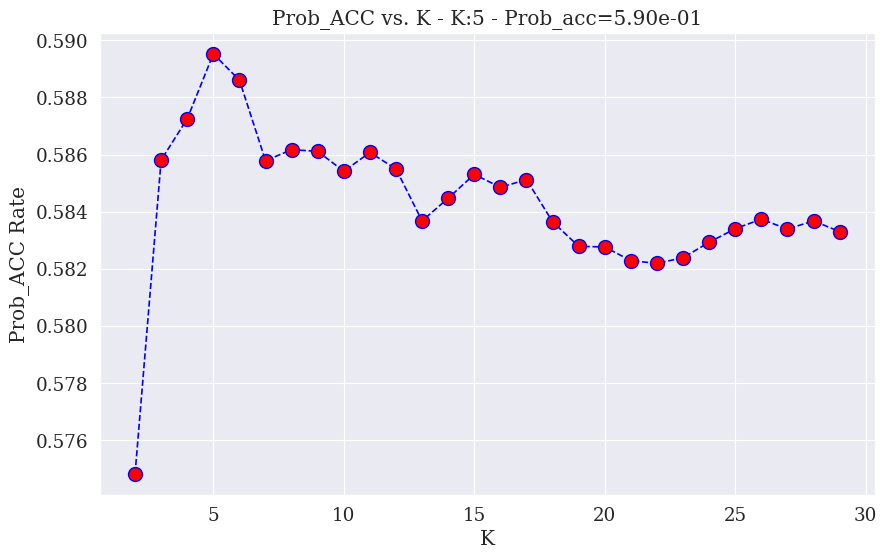

✔️ Melhor K encontrado: 5


Calculating SV Matrix: 100%|██████████| 1851/1851 [00:23<00:00, 77.66it/s]


✔️ sv_eop calculado com shape: (4316,)

🔍 Resultados para: Caucasian - Aware - FairShap
              precision    recall  f1-score   support

           0       0.66      0.64      0.65      1008
           1       0.58      0.60      0.59       843

    accuracy                           0.62      1851
   macro avg       0.62      0.62      0.62      1851
weighted avg       0.62      0.62      0.62      1851



In [265]:
X_scaled = copia.copy()


#só uma coluna referente a raça
X_scaled = X_scaled.drop(columns=['AfricanAmerican'], axis=1)

# 🔀 Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.3,
    random_state=42,
    stratify=y  # Mantém a proporção das classes
)
feature_names = X_scaled.columns.tolist()

weights,fair_sv_extractor =pipeline_fairshap(
    X_train, X_test, y_train, y_test,
    protected_attribute_col='Caucasian',
    privileged_value=1,
    unprivileged_value=0,
    label_favorable=0,  # Verificar seu dataset
    label_unfavorable=1,
    feature_names=feature_names,
    remove_sensitive=False,  # Testando mantendo a coluna
    label="CaucasianPA"
)

fairshap_causasian = pipeline_baseline(X_train, X_test, y_train, y_test, 
                                       label="Caucasian - Aware - FairShap", weights=weights)


## Fair Shap AfricanAmerican Aware

# Calculating TSNE


c:\Users\Davi Araujo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
Finding best k: 100%|██████████| 28/28 [00:02<00:00, 13.52it/s]


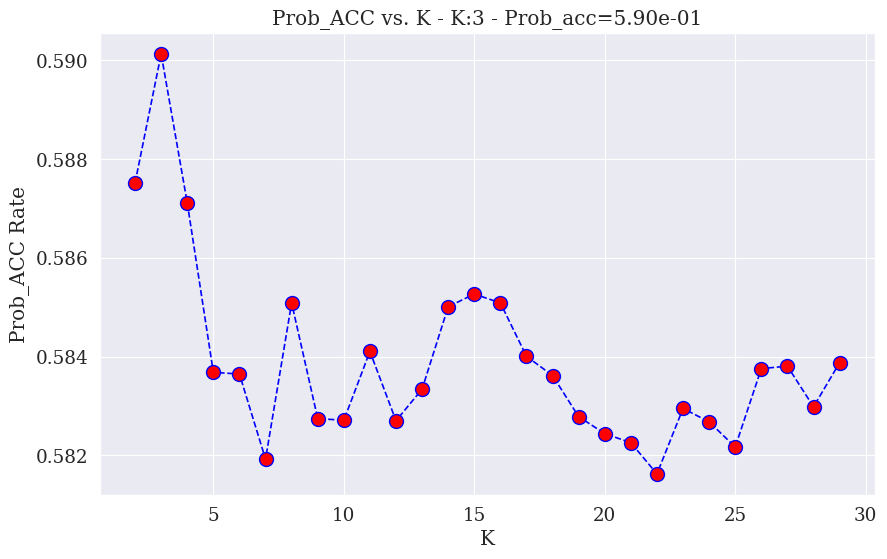

✔️ Melhor K encontrado: 3


Calculating SV Matrix: 100%|██████████| 1851/1851 [00:24<00:00, 76.38it/s]


✔️ sv_eop calculado com shape: (4316,)

🔍 Resultados para: AfricanAmerican - Aware - FairShap
              precision    recall  f1-score   support

           0       0.67      0.75      0.71      1008
           1       0.65      0.55      0.60       843

    accuracy                           0.66      1851
   macro avg       0.66      0.65      0.65      1851
weighted avg       0.66      0.66      0.66      1851



In [266]:
X_scaled = copia.copy()


#só uma coluna referente a raça
X_scaled = X_scaled.drop(columns=['Caucasian'], axis=1)

# 🔀 Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.3,
    random_state=42,
    stratify=y  # Mantém a proporção das classes
)
feature_names = X_scaled.columns.tolist()

weights,fair_sv_extractor =pipeline_fairshap(
    X_train, X_test, y_train, y_test,
    protected_attribute_col='AfricanAmerican',
    privileged_value=0,
    unprivileged_value=1,
    label_favorable=0,  # Verificar seu dataset
    label_unfavorable=1,
    feature_names=feature_names,
    remove_sensitive=False,  # Testando mantendo a coluna
    label="AfricanAmerican"
)

fairshap_african = pipeline_baseline(X_train, X_test, y_train, y_test, 
                                       label="AfricanAmerican - Aware - FairShap", weights=weights)


In [268]:
from sklearn.metrics import confusion_matrix
import numpy as np

# 🔧 Função para calcular Equalized Odds
def equalized_odds(y_true, y_pred, protected):
    groups = np.unique(protected)
    results = {}
    
    for group in groups:
        mask = protected == group
        tp = np.sum((y_true[mask] == 1) & (y_pred[mask] == 1))
        fp = np.sum((y_true[mask] == 0) & (y_pred[mask] == 1))
        fn = np.sum((y_true[mask] == 1) & (y_pred[mask] == 0))
        tn = np.sum((y_true[mask] == 0) & (y_pred[mask] == 0))
        
        tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
        
        results[group] = {'TPR': tpr, 'FPR': fpr}
    
    groups_list = list(groups)
    g1, g2 = groups_list[0], groups_list[1]
    
    tpr_diff = abs(results[g1]['TPR'] - results[g2]['TPR'])
    fpr_diff = abs(results[g1]['FPR'] - results[g2]['FPR'])
    
    equalized_odds = max(tpr_diff, fpr_diff)
    
    return equalized_odds, results


# 🔍 Predições dos dois modelos
X_scaled = copia.copy()
# 🔀 Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.3,
    random_state=42,
    stratify=y  # Mantém a proporção das classes
)
y_pred_baseline = baseline.predict(X_test)


# 🚀 Cálculo de Equalized Odds
protected_test = X_test['Caucasian'].values
eo_baseline_caucasian, details_baseline_caucasian = equalized_odds(y_test, y_pred_baseline, protected_test)
protected_test = X_test['AfricanAmerican'].values
eo_baseline_african, details_baseline_african = equalized_odds(y_test, y_pred_baseline, protected_test)


#Tem colunas diferentes e refazer
X_scaled = copia.copy()
X_scaled = X_scaled.drop(columns=['AfricanAmerican'], axis=1)
# 🔀 Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.3,
    random_state=42,
    stratify=y  # Mantém a proporção das classes
)
y_pred_fairshap = fairshap_causasian.predict(X_test)
protected_test = X_test['Caucasian'].values
eo_fairshap_caucasian, details_fairshap_caucasian = equalized_odds(y_test, y_pred_fairshap, protected_test)

#Tem colunas diferentes e refazer
X_scaled = copia.copy()
X_scaled = X_scaled.drop(columns=['Caucasian'], axis=1)
# 🔀 Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.3,
    random_state=42,
    stratify=y  # Mantém a proporção das classes
)
y_pred_fairshap = fairshap_african.predict(X_test)
protected_test = X_test['AfricanAmerican'].values
eo_fairshap_african, details_fairshap_african = equalized_odds(y_test, y_pred_fairshap, protected_test)

# 🔥 Resultados
print("🔍 Equalized Odds - Baseline - Caucasian:", eo_baseline_caucasian)
print("🔍 Equalized Odds - Baseline - African:", eo_baseline_african)
#print("Detalhes:", details_baseline)
print("🔍 Equalized Odds - FairShap - Caucasian:", eo_fairshap_caucasian)
print("🔍 Equalized Odds - FairShap - African:", eo_fairshap_african)
#print("Detalhes:", details_fairshap)


🔍 Equalized Odds - Baseline - Caucasian: 0.27835820895522384
🔍 Equalized Odds - Baseline - African: 0.29998467451017374
🔍 Equalized Odds - FairShap - Caucasian: 0.5153061224489796
🔍 Equalized Odds - FairShap - African: 0.06720816730719348


### All Aware

# Calculating TSNE


c:\Users\Davi Araujo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
Finding best k: 100%|██████████| 28/28 [00:02<00:00, 12.92it/s]


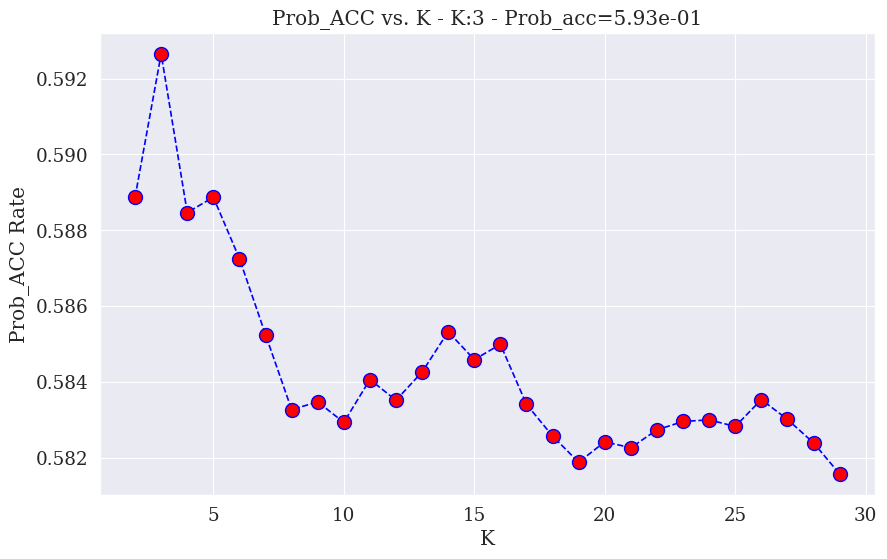

✔️ Melhor K encontrado: 3


Calculating SV Matrix: 100%|██████████| 1851/1851 [00:23<00:00, 79.68it/s]


✔️ sv_eop calculado com shape: (4316,)

🔍 Resultados para: Caucasian - Aware - FairShap
              precision    recall  f1-score   support

           0       0.67      0.70      0.69      1008
           1       0.62      0.59      0.61       843

    accuracy                           0.65      1851
   macro avg       0.65      0.65      0.65      1851
weighted avg       0.65      0.65      0.65      1851

# Calculating TSNE


c:\Users\Davi Araujo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
Finding best k: 100%|██████████| 28/28 [00:02<00:00, 12.63it/s]


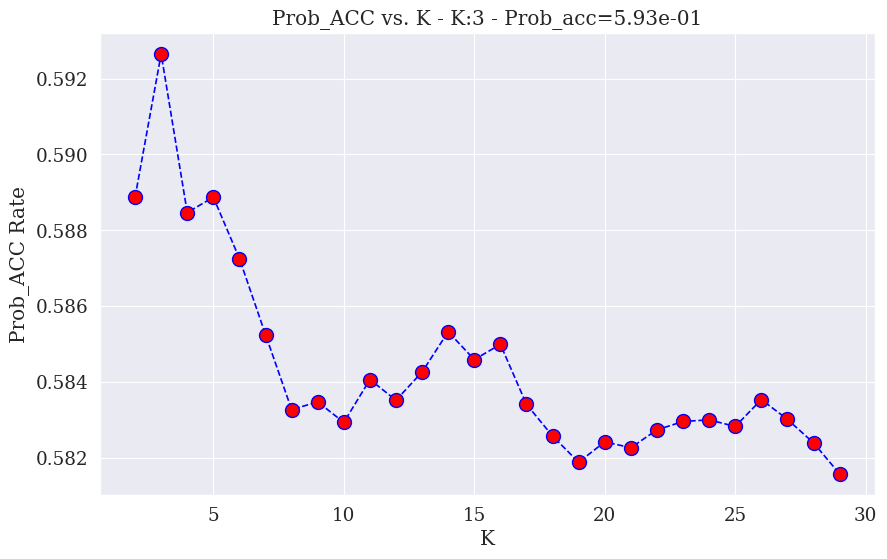

✔️ Melhor K encontrado: 3


Calculating SV Matrix: 100%|██████████| 1851/1851 [00:23<00:00, 78.46it/s]


✔️ sv_eop calculado com shape: (4316,)

🔍 Resultados para: AfricanAmerican - Aware - FairShap
              precision    recall  f1-score   support

           0       0.67      0.74      0.71      1008
           1       0.65      0.56      0.60       843

    accuracy                           0.66      1851
   macro avg       0.66      0.65      0.65      1851
weighted avg       0.66      0.66      0.66      1851



In [269]:
X_scaled = copia.copy()


#só uma coluna referente a raça
#X_scaled = X_scaled.drop(columns=['AfricanAmerican'], axis=1)

# 🔀 Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.3,
    random_state=42,
    stratify=y  # Mantém a proporção das classes
)
feature_names = X_scaled.columns.tolist()

weights,fair_sv_extractor =pipeline_fairshap(
    X_train, X_test, y_train, y_test,
    protected_attribute_col='Caucasian',
    privileged_value=1,
    unprivileged_value=0,
    label_favorable=0,  # Verificar seu dataset
    label_unfavorable=1,
    feature_names=feature_names,
    remove_sensitive=False,  # Testando mantendo a coluna
    label="CaucasianPA"
)

fairshap_causasian = pipeline_baseline(X_train, X_test, y_train, y_test, 
                                       label="Caucasian - Aware - FairShap", weights=weights)

X_scaled = copia.copy()


#só uma coluna referente a raça
#X_scaled = X_scaled.drop(columns=['Caucasian'], axis=1)

# 🔀 Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.3,
    random_state=42,
    stratify=y  # Mantém a proporção das classes
)
feature_names = X_scaled.columns.tolist()

weights,fair_sv_extractor =pipeline_fairshap(
    X_train, X_test, y_train, y_test,
    protected_attribute_col='AfricanAmerican',
    privileged_value=0,
    unprivileged_value=1,
    label_favorable=0,  # Verificar seu dataset
    label_unfavorable=1,
    feature_names=feature_names,
    remove_sensitive=False,  # Testando mantendo a coluna
    label="AfricanAmerican"
)

fairshap_african = pipeline_baseline(X_train, X_test, y_train, y_test, 
                                       label="AfricanAmerican - Aware - FairShap", weights=weights)



In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# 🔧 Função para calcular Equalized Odds
def equalized_odds(y_true, y_pred, protected):
    groups = np.unique(protected)
    results = {}
    
    for group in groups:
        mask = protected == group
        tp = np.sum((y_true[mask] == 1) & (y_pred[mask] == 1))
        fp = np.sum((y_true[mask] == 0) & (y_pred[mask] == 1))
        fn = np.sum((y_true[mask] == 1) & (y_pred[mask] == 0))
        tn = np.sum((y_true[mask] == 0) & (y_pred[mask] == 0))
        
        tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
        
        results[group] = {'TPR': tpr, 'FPR': fpr}
    
    groups_list = list(groups)
    g1, g2 = groups_list[0], groups_list[1]
    
    tpr_diff = abs(results[g1]['TPR'] - results[g2]['TPR'])
    fpr_diff = abs(results[g1]['FPR'] - results[g2]['FPR'])
    
    equalized_odds = max(tpr_diff, fpr_diff)
    
    return equalized_odds, results


# 🔍 Predições dos dois modelos
X_scaled = copia.copy()
# 🔀 Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.3,
    random_state=42,
    stratify=y  # Mantém a proporção das classes
)
y_pred_baseline = baseline.predict(X_test)
y_pred_fairshap_caucasian = fairshap_causasian.predict(X_test)
y_pred_fairshap_african = fairshap_african.predict(X_test)


# 🚀 Cálculo de Equalized Odds
protected_test = X_test['Caucasian'].values
eo_baseline_caucasian, details_baseline_caucasian = equalized_odds(y_test, y_pred_baseline, protected_test)
protected_test = X_test['AfricanAmerican'].values
eo_baseline_african, details_baseline_african = equalized_odds(y_test, y_pred_baseline, protected_test)
protected_test = X_test['Caucasian'].values
#protected_test = X_test['AfricanAmerican'].values
eo_fairshap_caucasian, details_fairshap_caucasian = equalized_odds(y_test, y_pred_fairshap_caucasian, protected_test)
protected_test = X_test['Caucasian'].values
protected_test = X_test['AfricanAmerican'].values
eo_fairshap_african, details_fairshap_african = equalized_odds(y_test, y_pred_fairshap_african, protected_test)

# 🔥 Resultados
print("🔍 Equalized Odds - Baseline - Caucasian:", eo_baseline_caucasian)
print("🔍 Equalized Odds - Baseline - African:", eo_baseline_african)
#print("Detalhes:", details_baseline)
#print("\n")
print("🔍 Equalized Odds - FairShap - Caucasian:", eo_fairshap_caucasian)
print("🔍 Equalized Odds - FairShap - African:", eo_fairshap_african)
#print("Detalhes:", details_fairshap)


🔍 Equalized Odds - Baseline - Caucasian: 0.27835820895522384
🔍 Equalized Odds - Baseline - African: 0.29998467451017374
🔍 Equalized Odds - FairShap - Caucasian: 0.26205936920222633
🔍 Equalized Odds - FairShap - African: 0.10551948051948054


In [262]:
print(pd.crosstab(X['Caucasian'], y, rownames=['Caucasian'], colnames=['Label']))
print(pd.crosstab(X['AfricanAmerican'], y, rownames=['AfricanAmerican'], colnames=['Label']))

Label         0     1
Caucasian            
0          2080  1987
1          1278   822
Label               0     1
AfricanAmerican            
0                1846  1148
1                1512  1661
